# Parallel training using DistributedStrategy


# Time series prediction with LSTM (IOT Data)


[Solar power forecasting](https://en.wikipedia.org/wiki/Solar_power_forecasting) is a challenging and important problem. The solar energy generation forecasting problem is closely linked to the problem of weather variables forecasting. Indeed, this problem is usually split into two parts, on one hand focusing on the forecasting of solar PV or any other meteorological variable and on the other hand estimating the amount of energy that a concrete power plant will produce with the estimated meteorological resource. In general, the way to deal with this difficult problem is usually related to the spatial and temporal scales we are interested in. This tutorial focusses on a simplified forecasting model using previously generated data from solar panel to predict the future. 

Using historic daily production of a solar panel, we want to predict the total power production of the solar panel array for a day. We will be using the LSTM based time series prediction model to predict the daily output of a solar panel based on the initial readings of the day. 

We train the model with historical data of the solar panel. In our example we want to predict the total power production of the solar panel array for the day starting with the initial readings of the day. We start predicting after the first 2 readings and adjust the prediction with each new reading.



### Data preparation

Our solar panel, emits two measures at every 30 min interval:
- `solar.current` is the current production in Watt
- `solar.total` is the total produced for the day so far 

Our prediction approach involves starting with the first 2 initial readings of the day. Based on these readings we start predicting and adjust the prediction with each new reading. The training data we are going to use comes as a csv file and has the following format:

>```
time,solar.current,solar.total
7am,6.3,1.7
7:30am,44.3,11.4
...
>```

The training dataset we use contains data captured for 3 years.
The dataset is not pre-processed: it is raw data and contains smaller gaps and errors (like a panel failed to report).

#### Pre-processing

`generate_solar_data()` function performs the following tasks:
- read raw data into a pandas dataframe, 
- normalize the data, 
- groups by day and 
- append the columns "solar.current.max" and "solar.total.max", and
- generates the sequences for each day.

*Sequence generation*: All sequences are concatenated into a single list of sequences. There is *no more notion of timestamp* in our train input and **only** the sequences matter.

**Note** if we have less than 8 datapoints for a day we skip over the day assuming something is missing in the raw data. If we get more than 14 data points in a day we truncate the readings.

#### Training / Testing / Validation data preparation
We split the dataset in the following manner: pick in sequence, 8 values for training, 1 for validation and 1 for test until there is no more data. This will spread training, validation and test datasets across the full timeline while preserving time order.


In [16]:
import pandas as pd
import numpy as np

df = pd.read_csv('data/solar.csv')
df.head()

,time,solar.current,solar.total
0,2013-12-01 07:00:00,6.300000,1.69
1,2013-12-01 07:30:00,44.299999,11.36
2,2013-12-01 08:00:00,208.000000,67.50
3,2013-12-01 08:30:00,482.000000,250.50
4,2013-12-01 09:00:00,774.000000,573.50


In [18]:
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

def generate_solar_data(dataset_path, time_steps, normalize=1, val_size=0.1, test_size=0.1):
    """
    generate sequences to feed to rnn based on data frame with solar panel data
    the csv has the format: time ,solar.current, solar.total
     (solar.current is the current output in Watt, solar.total is the total production
      for the day so far in Watt hours)
    """
    
    df = pd.read_csv(dataset_path, index_col="time", parse_dates=['time'], dtype=np.float32)
    
    df["date"] = df.index.date
    
    # normalize data
    df['solar.current'] /= normalize
    df['solar.total'] /= normalize
    
    # group by day, find the max for a day and add a new column .max
    grouped = df.groupby(df.index.date).max()
    grouped.columns = ["solar.current.max", "solar.total.max", "date"]

    # merge continuous readings and daily max values into a single frame
    df_merged = pd.merge(df, grouped, right_index=True, on="date")
    df_merged = df_merged[["solar.current", "solar.total",
                           "solar.current.max", "solar.total.max"]]
    # we group by day so we can process a day at a time.
    grouped = df_merged.groupby(df_merged.index.date)
    per_day = []
    for _, group in grouped:
        per_day.append(group)

    # split the dataset into train, validatation and test sets on day boundaries
    val_size = int(len(per_day) * val_size)
    test_size = int(len(per_day) * test_size)
    next_val = 0
    next_test = 0

    result_x = {"train": [], "val": [], "test": []}
    result_y = {"train": [], "val": [], "test": []}    

    # generate sequences a day at a time
    for i, day in enumerate(per_day):
        # if we have less than 8 datapoints for a day we skip over the
        # day assuming something is missing in the raw data
        total = day["solar.total"].values.tolist()
        if len(total) < 8:
            continue
        if i >= next_val:
            current_set = "val"
            next_val = i + int(len(per_day) / val_size)
        elif i >= next_test:
            current_set = "test"
            next_test = i + int(len(per_day) / test_size)
        else:
            current_set = "train"
        max_total_for_day = np.array(day["solar.total.max"].values[0])
        for j in range(2, len(total)):
            result_x[current_set].append(total[0:j])
            result_y[current_set].append([max_total_for_day])
            if j >= time_steps:
                break
                
    # pad result_x sequences with 0 and convert to numpy.array
    # make result_y a numpy array
    for ds in ["train", "val", "test"]:
        sequences = pad_sequences(result_x[ds], dtype='float32')
        sequences = sequences.reshape((len(sequences), TIMESTEPS, 1))
        result_x[ds] = sequences
        result_y[ds] = np.array(result_y[ds])
    return result_x, result_y

In [20]:
# We keep up to 14 readings from a day
TIMESTEPS = 14

# 20000 is the maximum total output in our dataset. We normalize all values with this so our inputs are between 0.0 and 1.0 range

NORMALIZE = 20000

X, Y = generate_solar_data('data/solar.csv', TIMESTEPS, normalize=NORMALIZE)

In [21]:
print(X['train'].shape)
print(X['train'][0:3])

(10747, 14, 1)
[[[0.       ]
  [0.       ]
  [0.       ]
  [0.       ]
  [0.       ]
  [0.       ]
  [0.       ]
  [0.       ]
  [0.       ]
  [0.       ]
  [0.       ]
  [0.       ]
  [0.       ]
  [0.0006985]]

 [[0.       ]
  [0.       ]
  [0.       ]
  [0.       ]
  [0.       ]
  [0.       ]
  [0.       ]
  [0.       ]
  [0.       ]
  [0.       ]
  [0.       ]
  [0.       ]
  [0.0006985]
  [0.0033175]]

 [[0.       ]
  [0.       ]
  [0.       ]
  [0.       ]
  [0.       ]
  [0.       ]
  [0.       ]
  [0.       ]
  [0.       ]
  [0.       ]
  [0.       ]
  [0.0006985]
  [0.0033175]
  [0.010375 ]]]


In [22]:
print(Y['train'].shape)
print(Y['train'][0:3])

(10747, 1)
[[0.239]
 [0.239]
 [0.239]]


## Train LSTM network

Corresponding  to the maximum possible 14 data points in the input sequence, we model our network with 14 LSTM cells, 1 cell for each data point we take during the day. Since the input sequences can have varied points per sequence, we take the advantage of CNTK support for variable sequences as input to a LSTM so we can feed our sequences as-is with no additional need for padding.

The outputs from the LSTMs are fed into a dense layer and we randomly dropout 20% of the values to not overfit the model to the training set. The output of the dense layer becomes the prediction our model generates.

Notice: We lost the timestamp altogether; in our model only the sequences of readings matter. 

Our LSTM model has the following design:
![lstm](https://github.com/jakazmie/images-for-hands-on-labs/raw/master/lstm.png)

The network model is an exact translation of the network diagram above.

### Define a network

In [23]:
from tensorflow.python.keras.layers import Add
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.models import Sequential

def network_model(hidden_size):
    model = Sequential()
    model.add(LSTM(hidden_size, return_sequences=False, input_shape=(TIMESTEPS, 1)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    
    return model

hidden_size = 15
optimizer = 'rmsprop'
loss = 'mse'
metrics = ['mse']

model = network_model(hidden_size)

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

### Train model

In [25]:
from tensorflow.python.keras.callbacks import TensorBoard
from datetime import datetime


batch_size = 14
epochs = 50

now = datetime.now().strftime("%d-%m-%y-%H-%M")
logdir = "../../../logdir/{0}".format(now)
modelpath = "../../../SaveModel/model-{0}.h5".format(now)
tensorboard = TensorBoard(log_dir=logdir)
run_history = model.fit(X['train'], Y['train'], batch_size=batch_size, epochs=epochs, validation_data = (X['val'], Y['val']), callbacks = [tensorboard])
model.save(modelpath)

Train on 10747 samples, validate on 1351 samples
Epoch 1/50
10747/10747 [==============================] - 10s 927us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 2/50
10747/10747 [==============================] - 9s 814us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 3/50
10747/10747 [==============================] - 9s 799us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 4/50
10747/10747 [==============================] - 9s 836us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 5/50
10747/10747 [==============================] - 9s 796us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 6/50
10747/10747 [==============================] - 8s 785us/step - loss: 0.0053 - mean_squared_error: 0

10747/10747 [==============================] - 9s 854us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 50/50
10747/10747 [==============================] - 9s 845us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0028 - val_mean_squared_error: 0.0028


### Load model and predict

In [26]:
from tensorflow.python.keras.models import load_model

model = load_model(modelpath)

In [27]:
result = model.predict(X['test'])

In [28]:
Y['test']

array([[0.505],
       [0.505],
       [0.505],
       ...,
       [0.276],
       [0.276],
       [0.276]], dtype=float32)

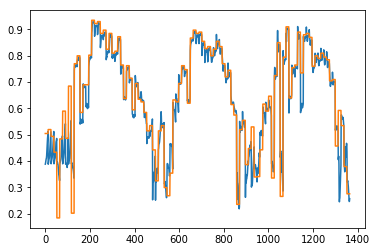

In [32]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(result)
plt.plot(Y['test'])